In [95]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("code")

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io.wavfile as wave
import IPython
import sklearn.decomposition as skd

import utils
import em

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
rate, _, mix = utils.readwav('data/mix.wav')
maxi = np.max(mix)
mix = mix / maxi

T, I = src1.shape
J = 3
print("rate = {}".format(rate))
print("T = {}".format(T))
print("I = {}".format(I))
print("J = {}".format(J))
IPython.display.Audio(mix.transpose(), rate = rate)

rate = 16000
T = 300801
I = 1
J = 3


In [104]:
def create_inputs(maxi):
    # load source mono wave files
    rate1, _, src1 = utils.readwav("data/src1.wav")
    rate2, _, src2 = utils.readwav("data/src2.wav")
    rate3, _, src3 = utils.readwav("data/src3.wav")
    src1 = src1 / maxi
    src2 = src2 / maxi
    src3 = src3 / maxi
    # create noised inputs by modifying source samples
    coef_mix = .05
    coef_noise = .01
    src1_ = ((1 - 2 * coef_mix) * src1 + coef_mix * src2 + coef_mix * src3) + np.random.normal(0, coef_noise, src1.shape)
    src2_ = (coef_mix * src1 + (1 - 2 * coef_mix) * src2 + coef_mix * src3) + np.random.normal(0, coef_noise, src1.shape)
    src3_ = (coef_mix * src1 + coef_mix * src2 + (1 - 2 * coef_mix) * src3) + np.random.normal(0, coef_noise, src1.shape)
    return np.concatenate(tuple([src1_, src2_, src3_]), axis=1).transpose()

sources = create_inputs(maxi)
J = sources.shape[0]
# IPython.display.Audio(in1.transpose() * maxi, rate = rate)
# IPython.display.Audio(in2.transpose() * maxi, rate = rate)
# IPython.display.Audio(in3.transpose() * maxi, rate = rate)

(3, 300801)


F = 501
N = 603


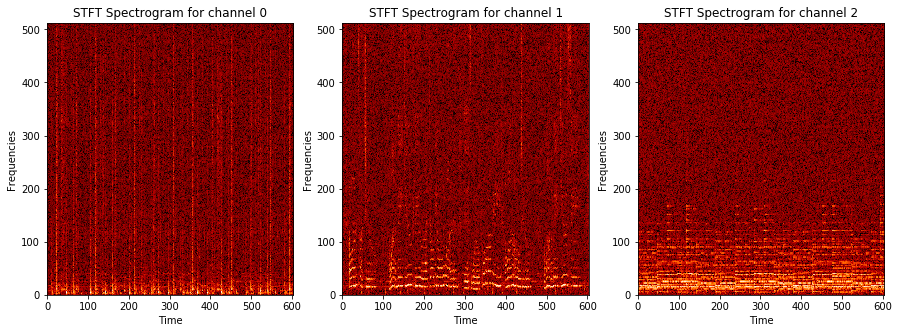

(3, 501, 603)
(501, 603, 3)


In [110]:
freqs, _, S = sig.stft(sources, fs=rate, nperseg=1000)
F = len(freqs)
N = S[0].shape[-1]
print("F = {}".format(F))
print("N = {}".format(N))

utils.plot_stft(freqs, S)
S = S.transpose(1, 2, 0)

In [119]:
def resynthesize_src(S, maxi):
    times, output = sig.istft(S.transpose((2, 0, 1)))
    return output * maxi

output = resynthesize_src(S, maxi)
IPython.display.Audio(output[0].transpose() * maxi, rate = rate)

In [93]:
Kpart = [5, 6, 8]
K = np.sum(Kpart)
A, W, H, sigma_b, H = em.init_params(X, S, mix, Kpart)
print(W.shape, H.shape)

(501, 603, 3, 3)
[[5.86862874e-09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.61387112e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.36531873e-07]]


NameError: name 'A' is not defined

# Parameters of the model

In [5]:
A = np.zeros((I, J, F), dtype=complex)
W = np.zeros((F, K), dtype=complex)
H = np.zeros((K, N), dtype=complex)
Sb = np.zeros((F, I, I), dtype=complex)

A += np.random.random(A.shape)
W += np.random.random(W.shape)
H += np.random.random(H.shape)
Sb += np.random.random(Sb.shape)

In [ ]:
input = np.zeros(())

In [6]:
Rxs, Rss, u = em.compute_E_step(x_four, A, W, H, Sb, Kcal)
A, Sb, H, W = em.compute_M_step(Rxx, Rxs, Rss, u, H, W)

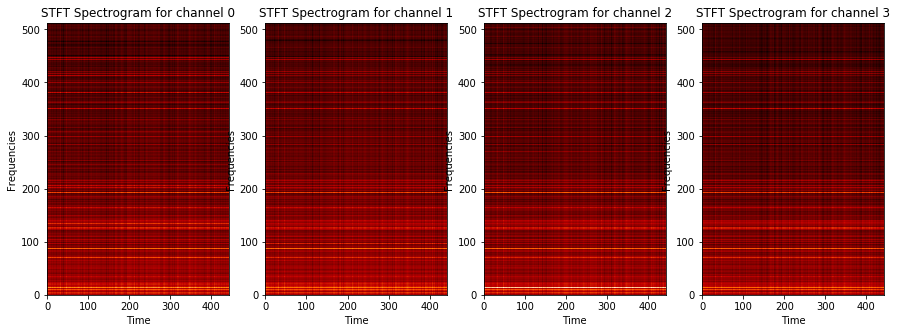

In [7]:
utils.plot_stft(np.array([W[:, i:i+1].dot(H[i:i+1, :]) for i in range(K)]))